## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_Karacayli2022
from cup1d.data import data_QMLE_Ohio
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Decide number of IGM free parameters (need to set this before creating theory)

In [2]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

### Setup real P1D measurement we are trying to mock

This will be use to get the list of redshifts, wavenumbers and covariances

In [3]:
# setup data to mimic, with a maximum z to avoid redshifts not emulated
data=data_Chabanier2019.P1D_Chabanier2019(zmin=2.0,zmax=4.5)
#data=data_QMLE_Ohio.P1D_QMLE_Ohio(zmin=2.0,zmax=4.5)
print(data.z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4]


In [4]:
# option to add extra P1D (high-resolution)
if True:
    extra_data=data_Karacayli2022.P1D_Karacayli2022(zmin=2.0,zmax=4.5)
else:
    extra_data=None

Nz = 15 , Nk = 21


### Setup emulator and theory

The emulator will be used both to make a mock, and in the likelihood 

In [5]:
emu=gp_emulator.GPEmulator(emu_type="polyfit",kmax_Mpc=8)
theory=lya_theory.Theory(zs=data.z,emulator=emu,free_param_names=free_param_names)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.21 seconds


In [6]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Create mock P1D data

Use Lya theory to mimic mock data

In [7]:
mock=mock_data.Mock_P1D(data=data,theory=theory)

In [8]:
# check if we also need mock extra_p1d
if extra_data:
    extra_theory=lya_theory.Theory(zs=extra_data.z,emulator=emu,
                                   free_param_names=free_param_names)
    extra_mock=mock_data.Mock_P1D(data=extra_data,theory=extra_theory)
else:
    extra_mock=None

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=mock,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_mock)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


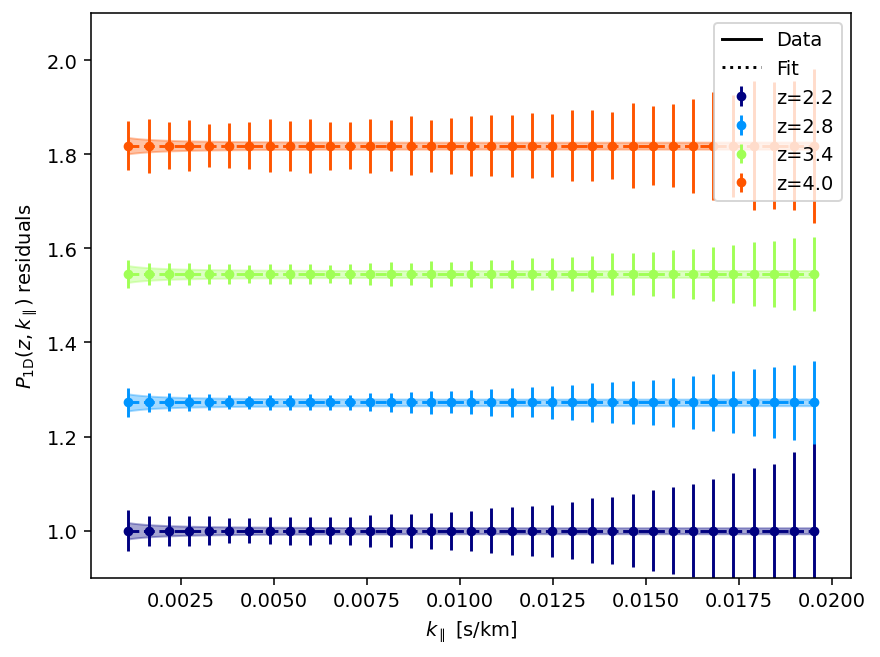

In [10]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=3)

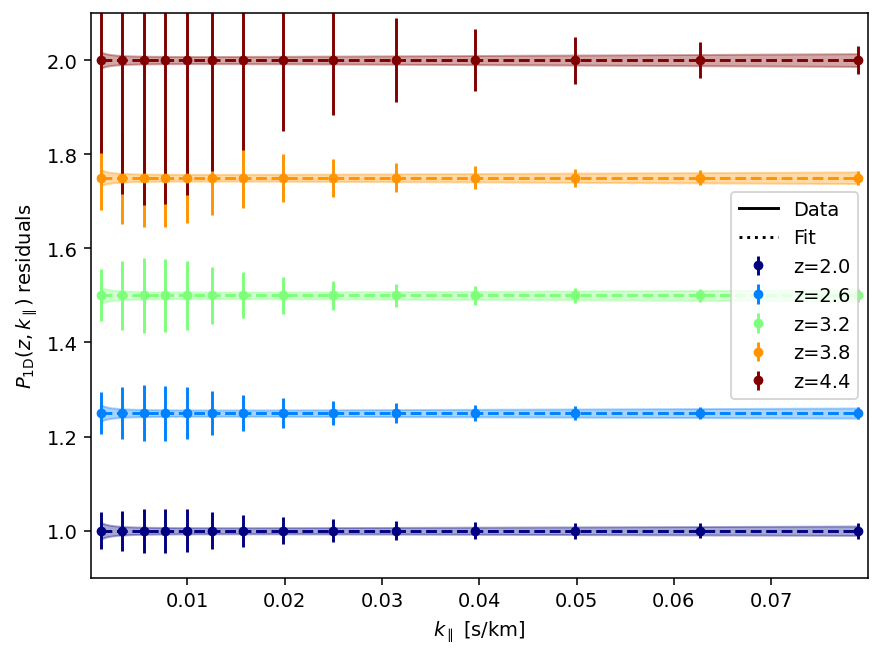

In [11]:
if extra_mock:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=3)

### Run iminuit minimizer

In [12]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.1
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.46233881 0.43512328 0.59548483 0.41252738 0.43566459 0.47050944
 0.59242717 0.58391729 0.40149924 0.52990336]
As = 2.0171453881566025e-09 , 1e-09 , 3.2e-09
ns = 0.9539709568550971 , 0.88 , 1.05
ln_tau_0 = 0.019096965743246527 , -0.1 , 0.1
ln_sigT_kms_0 = -0.06997809850110198 , -0.4 , 0.4
ln_gamma_0 = -0.025734163000655425 , -0.2 , 0.2
ln_kF_0 = -0.011796224169917296 , -0.2 , 0.2
ln_tau_1 = 0.03697086792757737 , -0.2 , 0.2
ln_sigT_kms_1 = 0.06713383393004663 , -0.4 , 0.4
ln_gamma_1 = -0.07880061099009394 , -0.4 , 0.4
ln_kF_1 = 0.023922684126412908 , -0.4 , 0.4


In [13]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [14]:
minimizer.minimize(compute_hesse=True)

In [15]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

9.745758466209408e-06

In [16]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

66.96391648689747

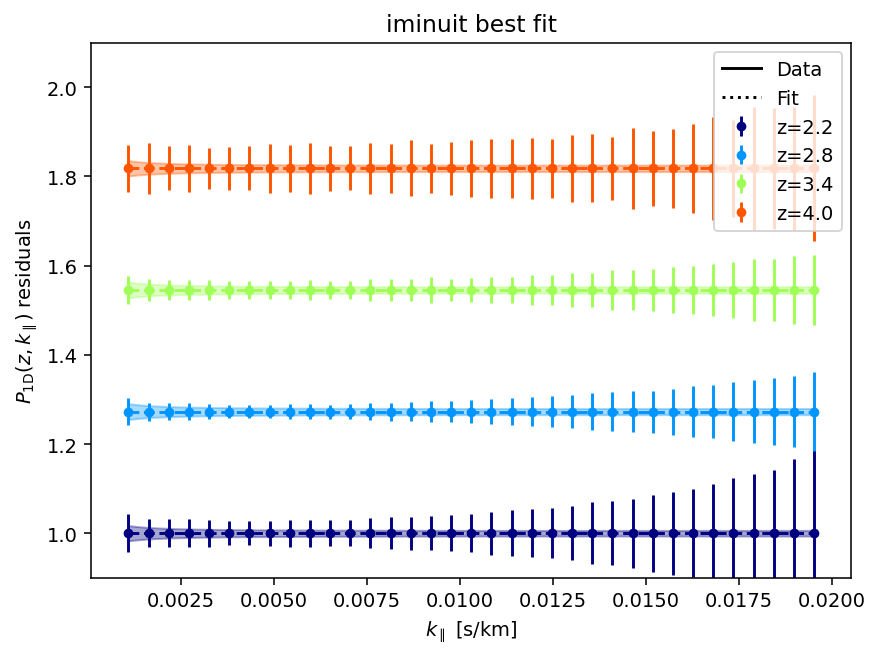

In [17]:
minimizer.plot_best_fit(plot_every_iz=3)

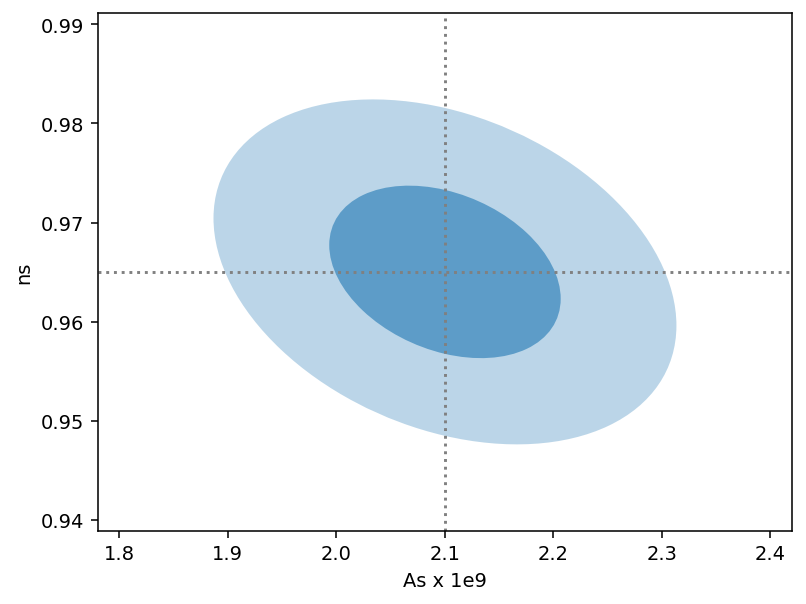

In [18]:
minimizer.plot_ellipses('As','ns')

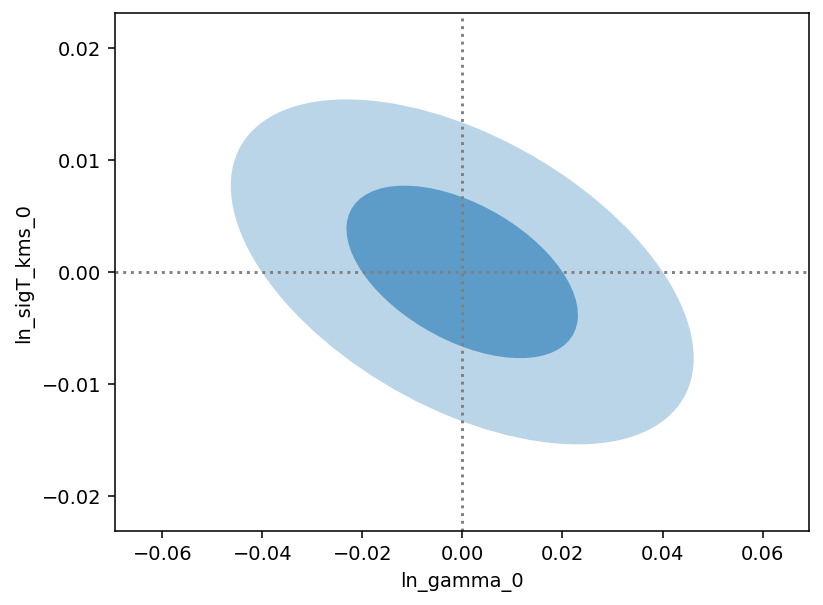

In [19]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

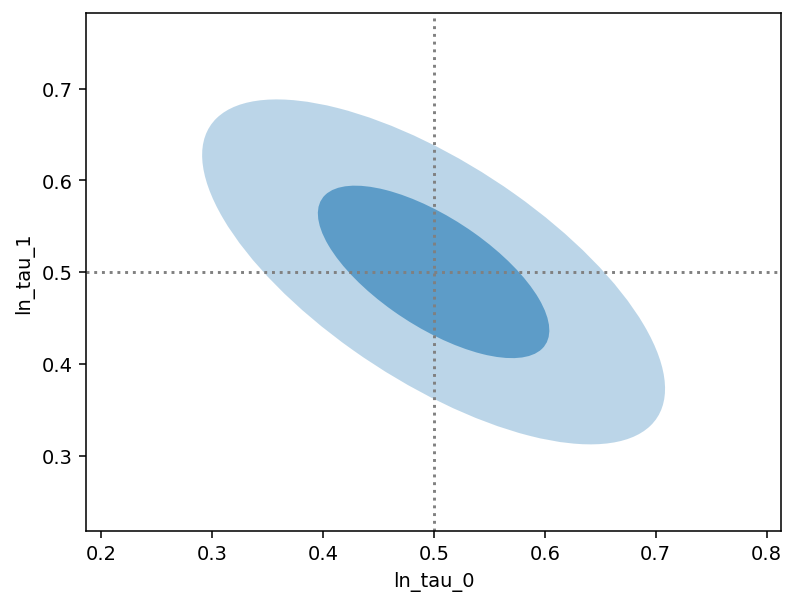

In [20]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [21]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 51.26                      │              Nfcn = 838              │
│ EDM = 1.72e-10 (Goal: 0.0001)    │           time = 11.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.50    │   0.05    │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.05    │            │            │         │         │       │
│ 2 │ x2   │    0.5    │    0.1    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.01    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.06    │            │            │         │         │       │
│ 5 │ x5   │   0.50    │   0.12    │            │            │         │         │       │
│ 6 │ x6   │   0.50    │   0.09    │            │            │         │         │       │
│ 7 │ x7   │   0.50    │   0.06    │            │            │         │         │       │
│ 8 │ x8   │   0.50    │   0.07    │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00235 -0.000773   -0.0048 -9.58e-05    -0.002   0.00488   0.00296   0.00115 -0.000312  -0.00278 │
│ x1 │ -0.000773   0.00262   0.00113  -8.4e-05   0.00108  -0.00364 -0.000986  -0.00146   0.00184 -0.000918 │
│ x2 │   -0.0048   0.00113    0.0109 -2.02e-05   0.00516  -0.00985  -0.00663  -0.00169  0.000531   0.00508 │
│ x3 │ -9.58e-05  -8.4e-05 -2.02e-05  9.28e-05 -0.000279 -0.000152  2.95e-05 -0.000197  -0.00011  0.000671 │
│ x4 │    -0.002   0.00108   0.00516 -0.000279   0.00334  -0.00438  -0.00337 -0.000234  0.000763   0.00049 │
│ x5 │   0.00488  -0.00364  -0.00985 -0.000152  -0.00438    0.0139     0.005   0.00509  -0.00344   -0.0048 │
│ x6 │   0.00296 -0.000986  -0.00663  2.95e-05  -0.00337     0.005   0.00882  -0.00102   0.00286  -0.00724 │
│ x7 │   0.00115  -0.00146  -0.00169 -0.000197 -0.000234   0.00509  -0.00102   0.00396  -0.00309 -0.000528 │
│ x8 │ -0.000312   0.00184  0.000531  -0.00011  0.000763  -0.00344   0.00286  -0.00309   0.00453  -0.00373 │
│ x9 │  -0.00278 -0.000918   0.00508  0.000671   0.00049   -0.0048  -0.00724 -0.000528  -0.00373    0.0149 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
minimizer.minimizer.errors

<ErrorView x0=0.04842886584549839 x1=0.051226531642444346 x2=0.10424092393967851 x3=0.009632860712873378 x4=0.05782634810811362 x5=0.11775812788044428 x6=0.09391856130359674 x7=0.06294981531010728 x8=0.06729446901062992 x9=0.12211108347352008>

In [23]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(3.788099092599806e-07, 0.020848184787935705)